In [4]:
# %% [markdown]
# # Calgary Economic Analysis
# ## Part 1: Oil Price Trends & Shock Identification (2010-2024)

# %% [markdown]
# ### Research Objectives:
# 1. Analyze WTI crude oil price trends from 2010-2024
# 2. Identify major price shocks (2014 crash, COVID-19, Ukraine war)
# 3. Establish baseline for Calgary economic correlation analysis

# %% [markdown]
# ### Data Sources:
# - WTI Crude Oil Prices (Yahoo Finance)
# - Time period: January 2010 - December 2024

# %% [code]
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("✅ Libraries imported")
print(f"Pandas version: {pd.__version__}")

# %% [code]
# Configuration
DATA_PATH = "../data/raw/"
OUTPUT_PATH = "../outputs/plots/"

# Create output directory if needed
import os
os.makedirs(OUTPUT_PATH, exist_ok=True)
os.makedirs(DATA_PATH, exist_ok=True)

print(f"Data path: {DATA_PATH}")
print(f"Output path: {OUTPUT_PATH}")

✅ Libraries imported
Pandas version: 2.3.3
Data path: ../data/raw/
Output path: ../outputs/plots/


In [5]:
# %% [code]
# Fetch oil price data
print("Downloading oil price data from Yahoo Finance...")

# Download from Yahoo Finance
oil = yf.download("CL=F", 
                  start="2010-01-01", 
                  end="2024-12-31",
                  progress=True)  # Show progress bar

# Check the data
print(f"\n✅ Data downloaded successfully!")
print(f"Data shape: {oil.shape}")
print("\nFirst 5 rows:")
print(oil.head())

print("\nColumn names:")
print(oil.columns)

print("\nDate range:")
print(f"Start: {oil.index[0]}")
print(f"End: {oil.index[-1]}")


[*********************100%***********************]  1 of 1 completed


✅ Data downloaded successfully!
Data shape: (3771, 5)

First 5 rows:
Price           Close       High        Low       Open  Volume
Ticker           CL=F       CL=F       CL=F       CL=F    CL=F
Date                                                          
2010-01-04  81.510002  81.680000  79.629997  79.629997  263542
2010-01-05  81.769997  82.000000  80.949997  81.629997  258887
2010-01-06  83.180000  83.519997  80.849998  81.430000  370059
2010-01-07  82.660004  83.360001  82.260002  83.199997  246632
2010-01-08  82.750000  83.470001  81.800003  82.650002  310377

Column names:
MultiIndex([( 'Close', 'CL=F'),
            (  'High', 'CL=F'),
            (   'Low', 'CL=F'),
            (  'Open', 'CL=F'),
            ('Volume', 'CL=F')],
           names=['Price', 'Ticker'])

Date range:
Start: 2010-01-04 00:00:00
End: 2024-12-30 00:00:00


In [9]:
# %% [code]
# Prepare the data for analysis
# Reset index to get Date as a column
oil_df = oil.reset_index()

print("Debug: After reset_index, columns are:")
print(oil_df.columns)
print("\nDebug: First few rows:")
print(oil_df.head())

# For Yahoo Finance MultiIndex data, we need to handle it differently
# The columns look like: ('Close', 'CL=F'), ('High', 'CL=F'), etc.

# Method 1: Flatten the MultiIndex columns
if isinstance(oil_df.columns, pd.MultiIndex):
    print("\nDetected MultiIndex columns. Flattening...")
    # Flatten the column names
    oil_df.columns = ['_'.join(col).strip() if col[1] else col[0] 
                     for col in oil_df.columns.values]
    print("Flattened columns:", oil_df.columns.tolist())

# Now rename based on what we actually have
# The price column is likely 'Close_CL=F' or 'Adj Close_CL=F'
column_map = {}
for col in oil_df.columns:
    col_lower = col.lower()
    if 'date' in col_lower:
        column_map[col] = 'date'
    elif 'close' in col_lower and 'adj' in col_lower:
        column_map[col] = 'price'
    elif 'close' in col_lower:
        column_map[col] = 'price'  # Use regular Close if Adj Close not available

print("\nColumn mapping to apply:", column_map)

# Rename columns
if column_map:
    oil_df = oil_df.rename(columns=column_map)
else:
    # Fallback: just rename the first columns
    oil_df.columns = ['date', 'price', 'high', 'low', 'open', 'volume']

# Keep only date and price columns (if they exist)
keep_cols = []
if 'date' in oil_df.columns:
    keep_cols.append('date')
if 'price' in oil_df.columns:
    keep_cols.append('price')

if len(keep_cols) >= 2:
    oil_df = oil_df[keep_cols].copy()
    print(f"\n✅ Keeping columns: {keep_cols}")
else:
    # Last resort: take first two columns
    oil_df = oil_df.iloc[:, :2].copy()
    oil_df.columns = ['date', 'price']
    print(f"\n⚠️  Using first two columns as date and price")

print("✅ Data cleaned and prepared")
print(f"Final data shape: {oil_df.shape}")
print("\nSample of prepared data:")
print(oil_df.head())

# Check data types
print("\nData types:")
print(oil_df.dtypes)

Debug: After reset_index, columns are:
MultiIndex([(  'Date',     ''),
            ( 'Close', 'CL=F'),
            (  'High', 'CL=F'),
            (   'Low', 'CL=F'),
            (  'Open', 'CL=F'),
            ('Volume', 'CL=F')],
           names=['Price', 'Ticker'])

Debug: First few rows:
Price        Date      Close       High        Low       Open  Volume
Ticker                  CL=F       CL=F       CL=F       CL=F    CL=F
0      2010-01-04  81.510002  81.680000  79.629997  79.629997  263542
1      2010-01-05  81.769997  82.000000  80.949997  81.629997  258887
2      2010-01-06  83.180000  83.519997  80.849998  81.430000  370059
3      2010-01-07  82.660004  83.360001  82.260002  83.199997  246632
4      2010-01-08  82.750000  83.470001  81.800003  82.650002  310377

Detected MultiIndex columns. Flattening...
Flattened columns: ['Date', 'Close_CL=F', 'High_CL=F', 'Low_CL=F', 'Open_CL=F', 'Volume_CL=F']

Column mapping to apply: {'Date': 'date', 'Close_CL=F': 'price'}

✅ Keeping 

In [10]:
# %% [code]
print("Extracting closing prices...")

# Method 1: If you want to keep it simple
oil_df = pd.DataFrame({
    'date': oil.index,
    'price': oil[('Close', 'CL=F')].values  # Direct access to MultiIndex
}).reset_index(drop=True)

print(f"✅ Extracted {len(oil_df)} rows")
print("\nFirst 5 rows:")
print(oil_df.head())

# Save
csv_path = os.path.join(DATA_PATH, "wti_crude_prices_2010_2024.csv")
oil_df.to_csv(csv_path, index=False)
print(f"\n✅ Saved to: {csv_path}")

Extracting closing prices...
✅ Extracted 3771 rows

First 5 rows:
        date      price
0 2010-01-04  81.510002
1 2010-01-05  81.769997
2 2010-01-06  83.180000
3 2010-01-07  82.660004
4 2010-01-08  82.750000

✅ Saved to: ../data/raw/wti_crude_prices_2010_2024.csv


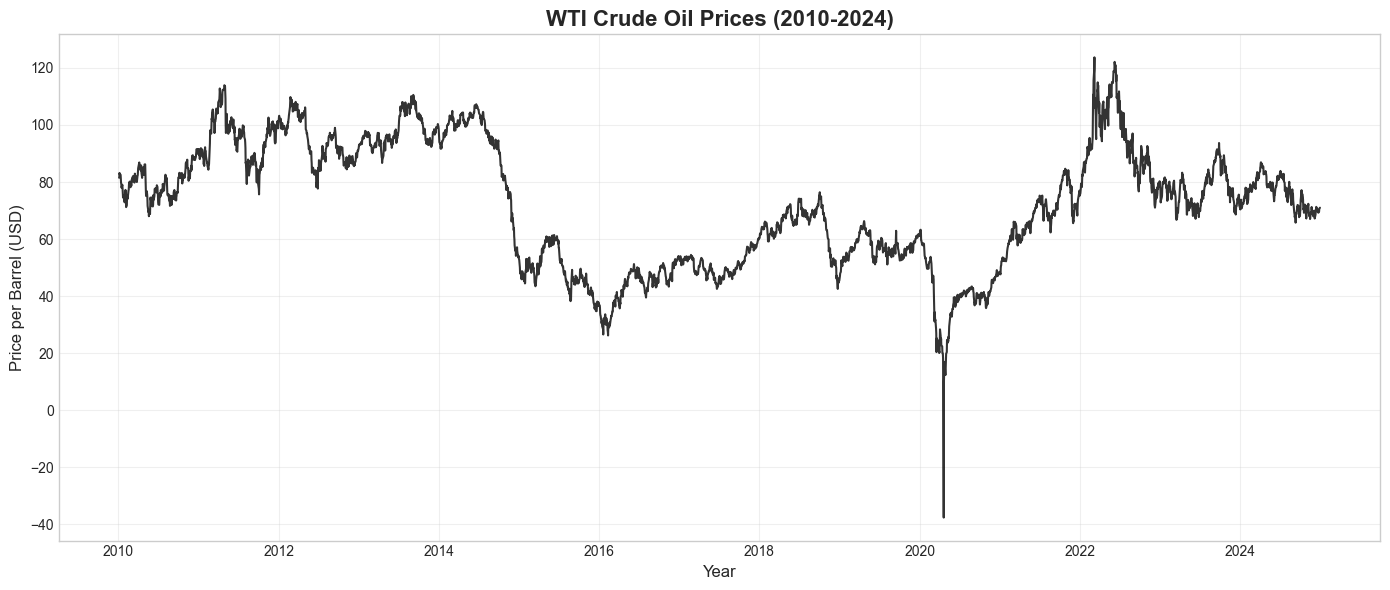

✅ Plot saved to: ../outputs/plots/oil_price_timeline.png


In [21]:
# Create first visualization: Oil price timeline
plt.figure(figsize=(14, 6))

# Plot the oil prices
plt.plot(oil_df['date'], oil_df['price'], 
         color='black', linewidth=1.5, alpha=0.8)

# Add title and labels
plt.title('WTI Crude Oil Prices (2010-2024)', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Price per Barrel (USD)', fontsize=12)
plt.grid(True, alpha=0.3)


# Add legend
plt.legend(loc='upper left')

# Save the plot
plot_path = os.path.join(OUTPUT_PATH, "oil_price_timeline.png")
plt.tight_layout()
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Plot saved to: {plot_path}")